In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_path="./"
save_dir = project_path + "saved_models/13-11-saved-models-cantho/"
data_path = project_path + "C1-6/C1-6_CanTho/"
filenames = ["C1", "C2", "C3", "C4", "C5", "C6"]
neurons = [5,8,10,12,15]
# neurons = [5,8]
optimizers = ['rmsprop', 'adagrad', 'adadelta', 'adam']
i = 0

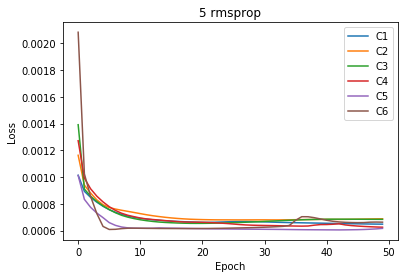

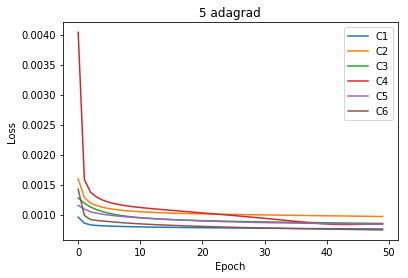

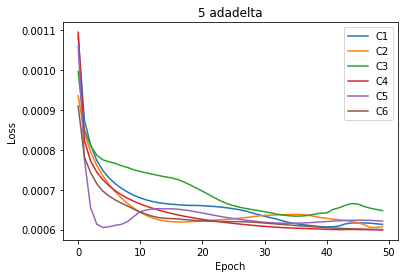

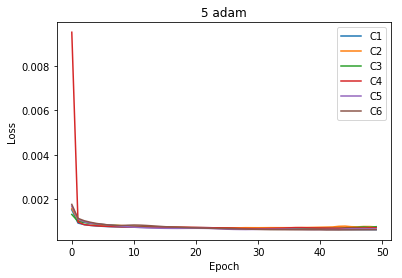

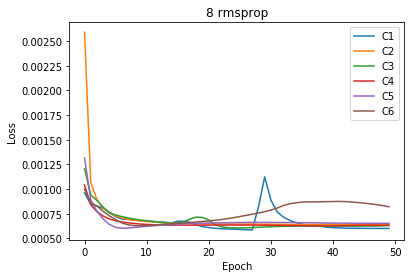

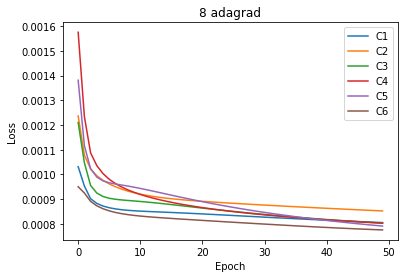

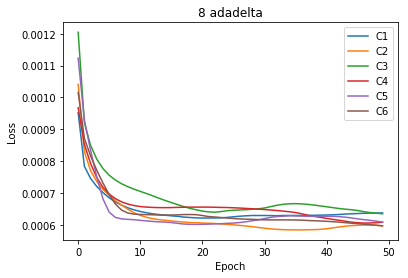

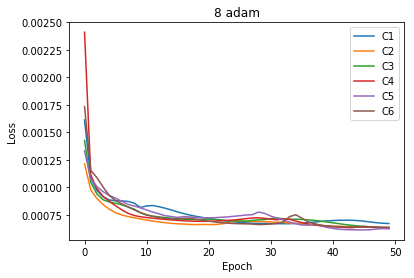

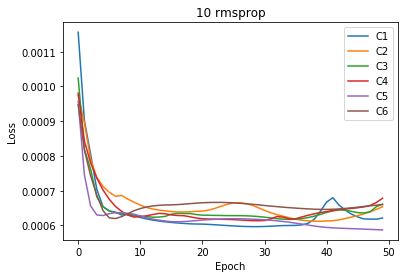

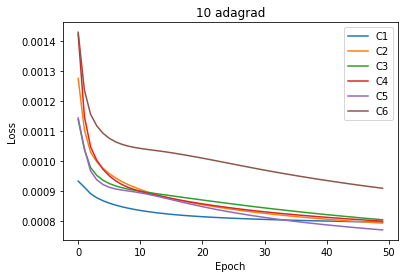

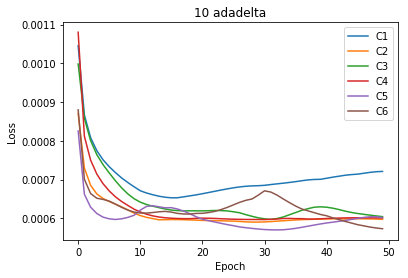

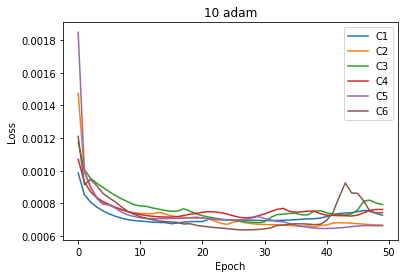

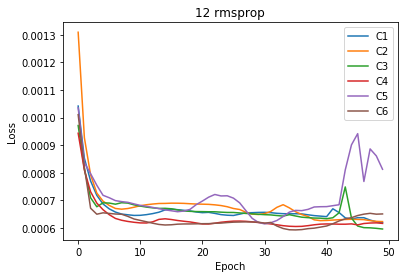

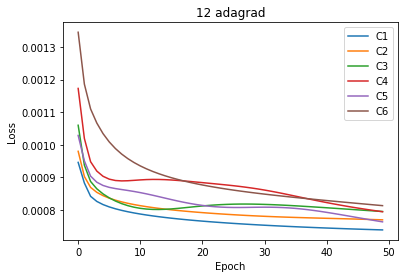

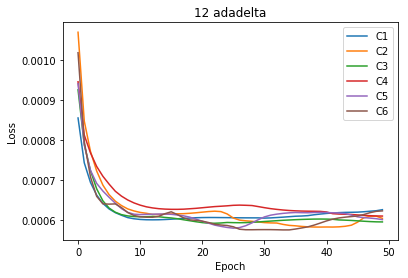

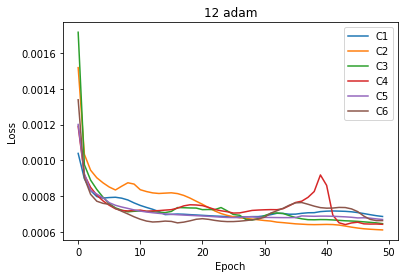

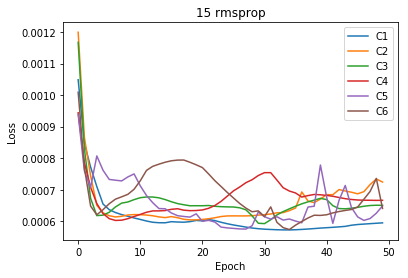

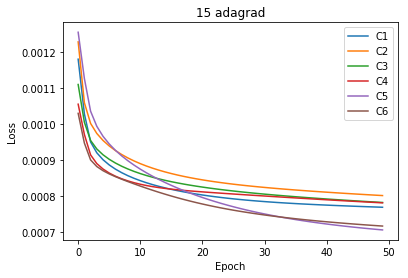

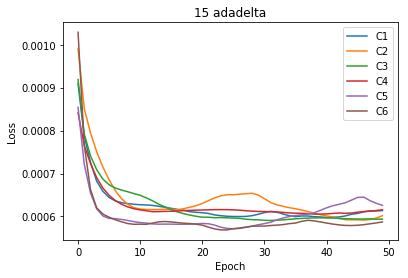

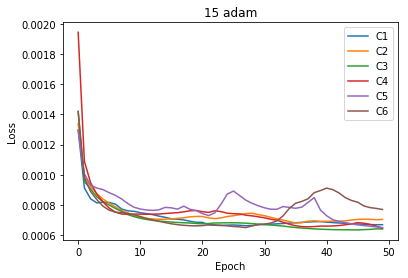

In [6]:
for neuron in neurons:
    for optimizer in optimizers:
        i+=1
        plt.figure(i)
        for filename in filenames:
            with open(save_dir + str(neuron) + '-' + filename + '-' + optimizer + '-history.json') as f:
                data = json.load(f)
            plt.plot(data)
        plt.title('{} {}'.format(neuron, optimizer))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['C1', 'C2', 'C3', 'C4', 'C5', 'C6'], loc='upper right')
        plt.savefig('./plots/{}-{}.eps'.format(neuron,optimizer), format='eps', dpi=1000)
    plt.show()